# Tutorial 4: MBHBs & MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

In the fourth tutorial we will examine MBHB waveforms. We will examine how to generate waveforms, add the LISA response, calculate the Likelihood, and then we will run an MCMC with MBHBs. 

## Task 1: Generate IMRPhenomHM waveforms

We will start by generating IMRPhenomHM waveforms for MBHBs. Pick reasonable parameters, build a waveform and plot it against the LISA Sensitivity Curve (`LISASens`) in the characteristic strain representation. **Hint**: set `f_ref = 0.0`. You can access the information after waveform generation as attributes on the class. This may be updated

Useful documentation:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [2]:
# imports 
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from lisatools.sensitivity import get_sensitivity

No CuPy or GPU PhenomHM module.


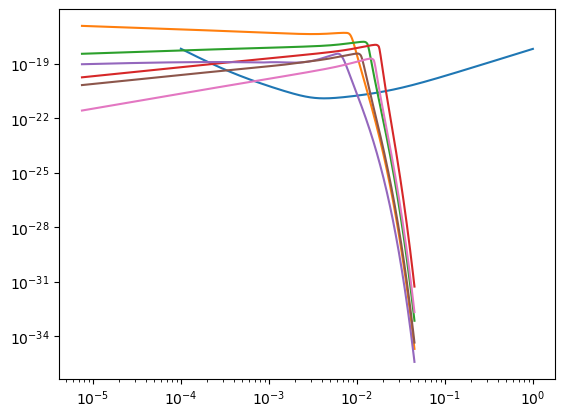

In [30]:
mbh_parameters = {
    "m1": 2e6,
    "m2": 7e5,
    "chi1z": 0.8,
    "chi2z": 0.7,
    "distance": 15* 1e9 * PC_SI, #3.08e25, # Luminosity distance in meters (1 Gpc)
    "phi_ref": 0,
    "f_ref": 0,# Reference frequency (0 means set internally)
    "t_ref": 1e6, # Reference time
}

generator = PhenomHMAmpPhase()

waveform = generator(**mbh_parameters, length=1000)

f = np.logspace(-4, 0, 1000)
sens = get_sensitivity(f, average = True, return_type = 'char_strain')

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(f, sens)

for i in range(6):
    chr_strain = generator.freqs * generator.amp[0,i]
    ax.plot(generator.freqs, chr_strain)


## Task 2: Add the response. 

Now repeat the same task as above by adding the response. In `BBHx`, the response is added automatically for you using the main waveform production class: `BBHWaveformFD`. The sensitivity for this should be `A1TDISens`.

Useful Documentation:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

In [31]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


(1, 3, 1000)


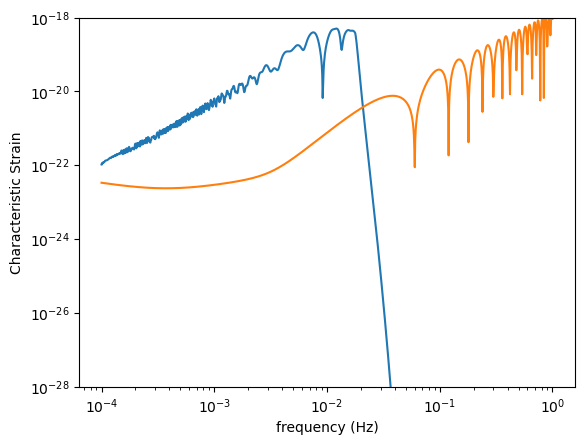

In [62]:
generator = BBHWaveformFD(response_kwargs={"TDItag":"AET"})

response_params = {
    "inc": np.pi/2.0, #Inclination radians
    "lam":np.pi, "beta":0.0, # Sky location
    "psi": np.pi/2.0, #polarization angle
    "t_obs_start": 0.1,# Observation start time in yrs
    "t_obs_end": 0.2 #end time of observation in years
}

f = np.logspace(-4, 0, 1000)

response = generator(**mbh_parameters, **response_params, freqs=f,  fill=True, direct=True)

print(response.shape)

fig, ax = plt.subplots()

ax.plot(f, np.abs(response[0][1])*f)

ax.set_xlabel("frequency (Hz)")
ax.set_xscale("log")
ax.set_ylabel("Characteristic Strain")
ax.set_yscale("log")

ax.set_ylim((1e-28, 1e-18))


sens = get_sensitivity(f, return_type = 'PSD', sens_fn="A1TDISens")

ax.plot(f, np.sqrt(sens) * np.sqrt(f))


0.0001
20000.0


/home/mtauraso/mambaforge/envs/lisa_env/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


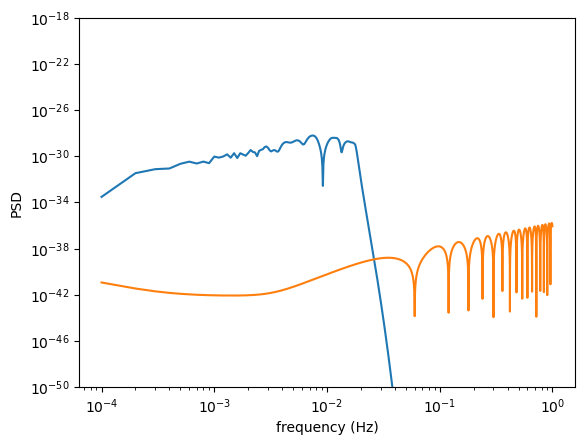

In [104]:
# Same thing as PSD
# < DOes not work at the moment>

#f = np.logspace(-4, 0, 1000)
f = np.linspace(1e-4, 1, 10000)
fig, ax = plt.subplots()

#df = f[1:]- f[:-1]

#f = f[:-1]

df = f[1] - f[0]

scale = 2/df
print(df)
print(scale)

response = generator(**mbh_parameters, **response_params, freqs=f,  fill=True, direct=True)

ax.plot(f,  scale * np.abs(response[0][0])**2 ) 
# Perhaps best (scipy welch), above is an approximation
from scipy.signal import welch

f2, pxx = welch(response[0][0], nfft=10000, window="tukey")

#ax.plot(f2, pxx) 



ax.set_xlabel("frequency (Hz)")
ax.set_xscale("log")
ax.set_ylabel("PSD")
ax.set_yscale("log")

ax.set_ylim((1e-50, 1e-18))


sens = get_sensitivity(f, return_type = 'PSD', sens_fn="A1TDISens")

ax.plot(f, sens)

## Task 3: Inject an MBHB and compute its SNR

Now we will combine our knowledge of `lisatools` with `bbhx`. Using the same methods above, setup a full `AnalysisContainer` and inject an MBHB signal. Calculate its SNR. You will probably need to wrap the MBHB waveform generation to select out just the 1st array entry. 

In [67]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

/home/mtauraso/mambaforge/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mtauraso/mambaforge/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


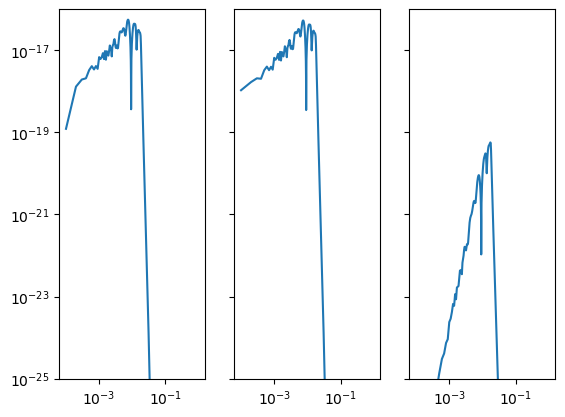

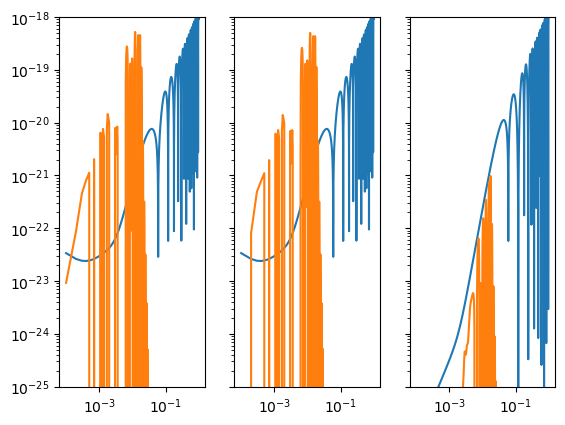

In [129]:
res = DataResidualArray(response[0], f_arr = f)
fig, axs = res.loglog()
for ax in axs: 
    ax.set_ylim((1e-25, 1e-16))


sense_mat = AET1SensitivityMatrix(f)

analysis_container = AnalysisContainer(res, sense_mat, signal_gen = generator)

fig, axs = analysis_container.loglog()
for ax in axs: 
    ax.set_ylim((1e-25, 1e-18))





In [127]:
mbh_parameters2 = {
    "m1": 2e6 + 1e6,
    "m2": 7e5,
    "chi1z": 0.8,
    "chi2z": 0.7,
    "distance": 15* 1e9 * PC_SI, #3.08e25, # Luminosity distance in meters (1 Gpc)
    "phi_ref": 0,
    "f_ref": 0,# Reference frequency (0 means set internally)
    "t_ref": 1e6, # Reference time
}

response_params2 = {
    "inc": np.pi/2.0, #Inclination radians
    "lam":np.pi, "beta":0.0, # Sky location
    "psi": np.pi/2.0, #polarization angle
    "t_obs_start": 0.1,# Observation start time in yrs
    "t_obs_end": 0.2 #end time of observation in years
}
waveform_kwargs = mbh_parameters2
waveform_kwargs.update(response_params2)

waveform_kwargs.update({freqs:f,  fill:True, direct:True})
#mbh_parameters2 = [mbh_parameters2[key] for key in mbh_parameters2]
#response_params2 = [response_params2[key] for key in response_params2]



TypeError: 'dict_values' object is not subscriptable

Calculate the Likelihood using `calculate_signal_likelihood`. 

In [128]:
analysis_container.snr()
analysis_container.calculate_signal_snr(*mbh_parameters2,*response_params2, length=1000)

ValueError: Must input freqs or length.

## Task 4: MCMC with MBHBs

Now we will run an MCMC for MBHBs. Use your knowledge from our tutorial on `Eryn` to run an MCMC for MBHBs. Let's run it for over four parameters: `(m1, m2, phi_ref, t_ref)`. You can use an `Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer) or a wrapper Likelihood to fill in fixed parameters. You can use the `periodic` kwarg for `EnsembleSampler` to run `phi_ref` as a periodic variable wrapping over the edge.

This will not be fast. Run the sampler for a small number of samples and move on to the next step. 

In [ ]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

## Task 5: Add heterodyning for speed

That would take a long time to complete a sampling run. One technique for speeding up waveforms is called `heterodyning`. Wrap the Heterodyned likelihood to use a subset of parameters. You can also use an Eryn `TransformFunction`. 

Useful Documentation:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [ ]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

Let's check how well the heterodyning method matches the base likelihood by sampling our prior. You will have to update the reference template for each computation since we are drawing from the prior and may be far away from our true point. You can do this with `HeterodynedLikelihood.init_heterdyne_info`. 

Setup and run the sampler. Then plot the posteriors using `ChainConsumer` or `corner`.